## Some setups

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

from vos.datasets.COCO import COCO
from vos.datasets.video_synth import VideoSynthDataset

root = "/p300/videoObjSeg_dataset/COCO-2017-train"
dataset = VideoSynthDataset(
    COCO(root, mode= "train", max_n_objects= 8),
    n_frames= 2,
    affine_kwargs= dict(
        angle_max= 15.,
        translate_max= 15.,
        scale_max= 0.1, # NOTE: this is the exponent of e
        shear_max= 15.
    ),
)

def make_batch(data):
    b_data = dict()
    for k, v in data.items():
        b_data[k] = v.unsqueeze(0)
        print(k, b_data[k].shape)
    return b_data
b_data = make_batch(dataset[0])

loading annotations into memory...
Done (t=26.77s)
creating index...
index created!
mask torch.Size([1, 2, 9, 384, 384])
n_objects torch.Size([1])
video torch.Size([1, 2, 3, 384, 384])


In [2]:
from torch.nn import DataParallel
from vos.models.STM import STM
from vos.algo.stm_train import STMAlgo

model = DataParallel(STM(train_bn= False))
algo = STMAlgo(
    include_bg_loss= False,
    clip_grad_norm= 1e9,
    learning_rate= 1e-5,
    weight_decay= 0,
    train_step_kwargs= dict(Mem_every= 1),
    eval_step_kwargs= dict(Mem_every= 5),
)

algo.initialize(model= model)
model.cuda()

Space-time Memory Networks: initialized.


DataParallel(
  (module): STM(
    (Encoder_M): Encoder_M(
      (conv1_m): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (conv1_o): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (res2): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d

## Check algorithm step method

In [3]:
dataset_len = len(dataset)
print(dataset_len)
idx = np.random.choice(dataset_len, 1)[0]
print(idx)
b_data = make_batch(dataset[idx])

118287
60081
mask torch.Size([1, 2, 9, 384, 384])
n_objects torch.Size([1])
video torch.Size([1, 2, 3, 384, 384])


In [4]:
pred, loss = algo.step(
    frames= b_data["video"],
    masks= b_data["mask"],
    n_objects= b_data["n_objects"],
    Mem_every= 1,
)
print(loss)
print(pred.shape, pred.dtype)

tensor(1.0017, grad_fn=<NllLoss2DBackward>)
torch.Size([1, 2, 9, 384, 384]) torch.uint8


## Viewing data

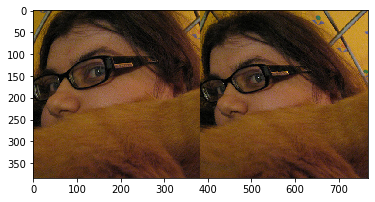

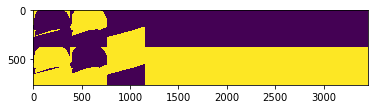

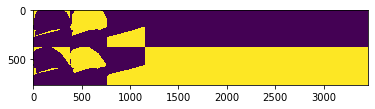

In [5]:
from vos.utils.helpers import stack_images, stack_masks
s_images = stack_images(b_data["video"].cpu().numpy())
s_pred = stack_masks(pred[0].cpu().numpy())
s_mask = stack_masks(b_data["mask"][0].cpu().numpy())

plt.imshow(s_images[0].transpose(1,2,0))
plt.figure()
plt.imshow(s_pred[0,0] * 255)
plt.figure()
plt.imshow(s_mask[0,0] * 255)